In [1]:
from datetime import datetime
import itertools
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
plt.style.use('fivethirtyeight')

In [2]:
from iexfinance.stocks import get_historical_data
def get_iex_data(stock_list, start=datetime(2015,1,1), end=datetime(2019,12,31)):
    return_list = []
    for i in stock_list:
        df = pd.DataFrame(get_historical_data(i, start, end, output_format='pandas', token='pk_d28c0190de7a4d6da30b3bd2b08487c8'))
        df['ticker'] = i
        return_list.append(df)
    return return_list

## Import Data

In [3]:
hun_etfs = ['MINT']
data = get_iex_data(hun_etfs)
data

[              open    high     low   close   volume ticker
 date                                                      
 2015-01-15  101.07  101.10  101.05  101.06   502762   MINT
 2015-01-16  101.10  101.10  100.99  100.99   335155   MINT
 2015-01-20  101.01  101.10  101.01  101.10   464080   MINT
 2015-01-21  101.06  101.10  101.01  101.02   357428   MINT
 2015-01-22  101.07  101.09  101.01  101.05   474671   MINT
 ...            ...     ...     ...     ...      ...    ...
 2019-12-24  101.66  101.70  101.66  101.70   477461   MINT
 2019-12-26  101.72  101.73  101.71  101.71   702694   MINT
 2019-12-27  101.72  101.74  101.72  101.74   872915   MINT
 2019-12-30  101.58  101.58  101.56  101.57  1267989   MINT
 2019-12-31  101.59  101.60  101.58  101.59  1023520   MINT
 
 [1249 rows x 6 columns]]

In [4]:
jnk = data[0]
jnk.to_csv('mint.csv', encoding='utf-8')

In [5]:
def clean_data(data):
    for i in range(len(data)):
        data[i] = data[i].reset_index()
        data[i]['date'] = pd.to_datetime(data[i]['date'])
        data[i] = data[i].set_index('date')
    return data

In [6]:
data = clean_data(data)

In [7]:
data

[              open    high     low   close   volume ticker
 date                                                      
 2015-01-15  101.07  101.10  101.05  101.06   502762   MINT
 2015-01-16  101.10  101.10  100.99  100.99   335155   MINT
 2015-01-20  101.01  101.10  101.01  101.10   464080   MINT
 2015-01-21  101.06  101.10  101.01  101.02   357428   MINT
 2015-01-22  101.07  101.09  101.01  101.05   474671   MINT
 ...            ...     ...     ...     ...      ...    ...
 2019-12-24  101.66  101.70  101.66  101.70   477461   MINT
 2019-12-26  101.72  101.73  101.71  101.71   702694   MINT
 2019-12-27  101.72  101.74  101.72  101.74   872915   MINT
 2019-12-30  101.58  101.58  101.56  101.57  1267989   MINT
 2019-12-31  101.59  101.60  101.58  101.59  1023520   MINT
 
 [1249 rows x 6 columns]]

In [8]:
ts = data[0]['close']

## ARIMA analysis

In [9]:
# p = d = q = range(0,3)
# pdq = list(itertools.product(p,d,q))
# pdqs = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(ts,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {} : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue    

In [10]:
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]

In [11]:
ARIMA_model = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 2, 2),
                                seasonal_order=(0, 0, 2, 5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
output = ARIMA_model.fit()
print(output.summary().tables[1])


C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0609      0.484     -0.126      0.900      -1.009       0.887
ar.L2         -0.0637      0.064     -0.995      0.320      -0.189       0.062
ma.L1         -1.0596      0.486     -2.182      0.029      -2.011      -0.108
ma.L2          0.0590      0.484      0.122      0.903      -0.890       1.008
ma.S.L5        0.0328      0.043      0.763      0.446      -0.052       0.117
ma.S.L10      -0.0404      0.041     -0.992      0.321      -0.120       0.039
sigma2         0.0015   4.77e-05     31.940      0.000       0.001       0.002


In [12]:
csv_output = output.summary().tables[1]

summary_df = pd.DataFrame(csv_output, index=None)
# csv_output.to_csv('spy_summary.csv', encoding='utf-8')
# csv_output
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df[1:]

summary_df.to_csv('mint_summary.csv', encoding='utf-8')
summary_df


,,coef,std err,z,P>|z|,[0.025,0.975]
1,ar.L1,-0.0609,0.484,-0.126,0.900,-1.009,0.887
2,ar.L2,-0.0637,0.064,-0.995,0.320,-0.189,0.062
3,ma.L1,-1.0596,0.486,-2.182,0.029,-2.011,-0.108
4,ma.L2,0.0590,0.484,0.122,0.903,-0.890,1.008
5,ma.S.L5,0.0328,0.043,0.763,0.446,-0.052,0.117
6,ma.S.L10,-0.0404,0.041,-0.992,0.321,-0.120,0.039
7,sigma2,0.0015,4.77e-05,31.940,0.000,0.001,0.002


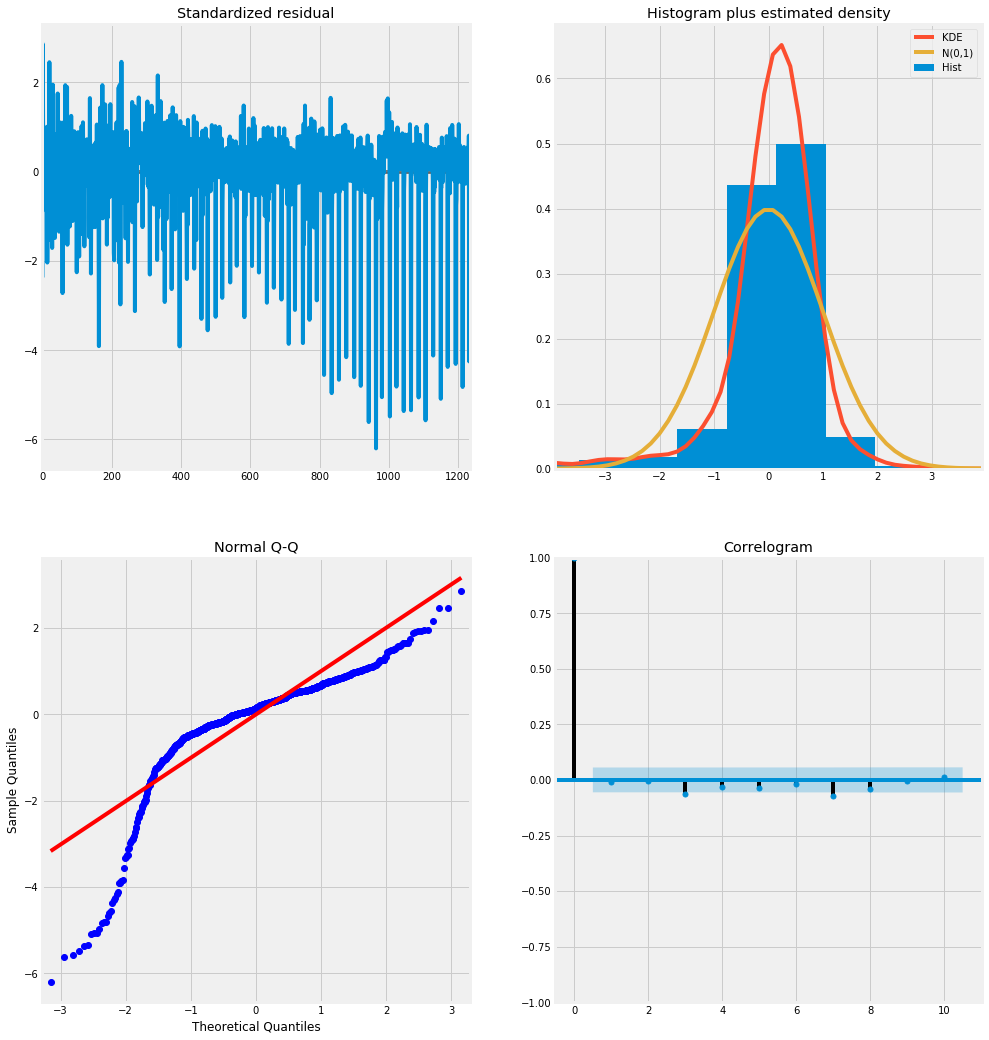

In [13]:
output.plot_diagnostics(figsize=(15, 18))
plt.savefig('mintoutput.png')
plt.show()

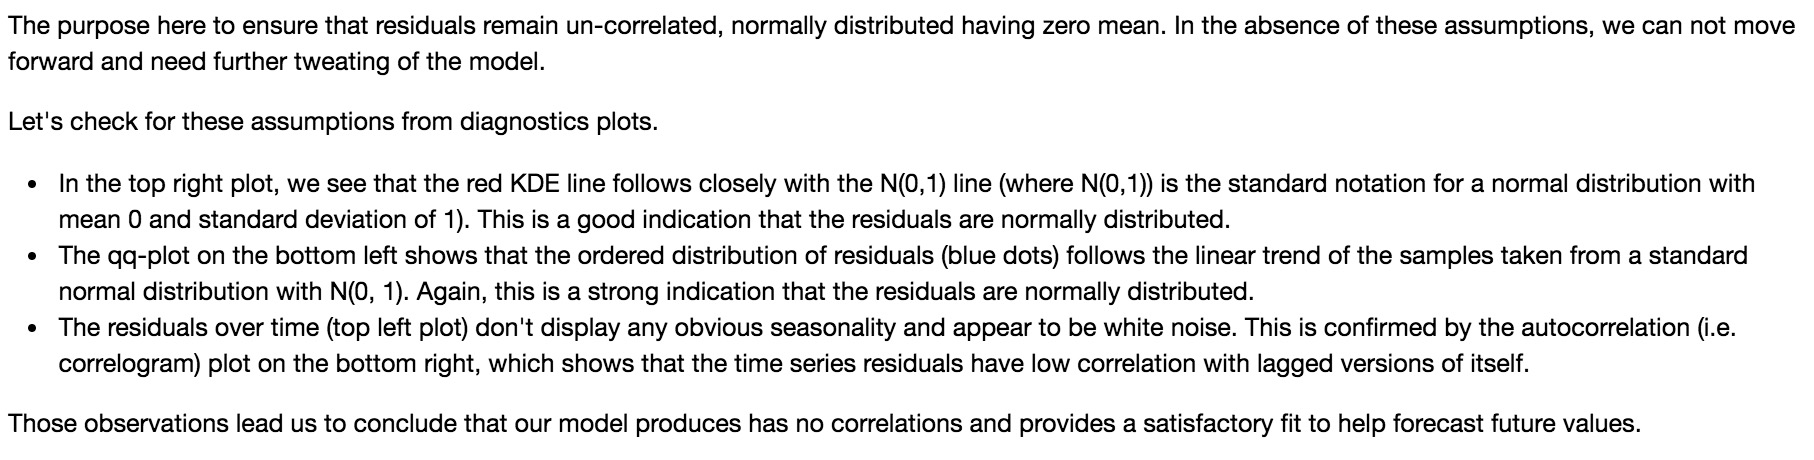

In [31]:
# plt.savefig('arima1.png')

<Figure size 432x288 with 0 Axes>

In [14]:
pred = output.get_prediction(start=pd.to_datetime('2019-11-01'), dynamic=False)
pred_conf = pred.conf_int()

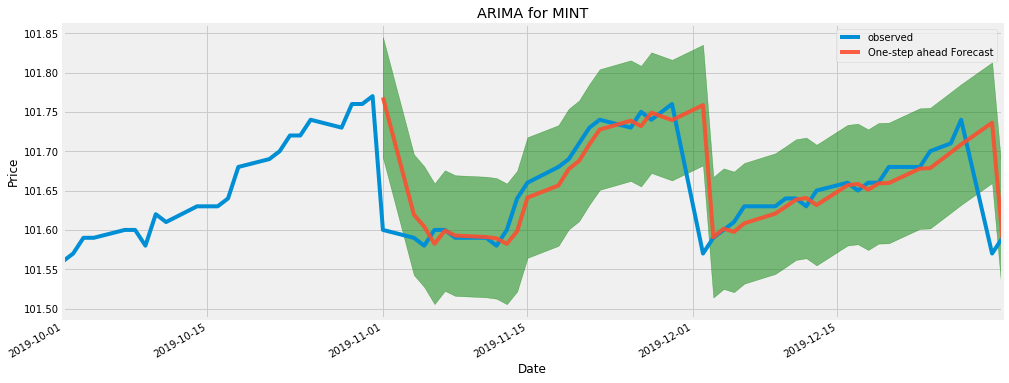

In [15]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = ts['2019-10':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
plt.title('ARIMA for MINT')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.savefig('mint_arima.png')
plt.show()

In [16]:
price_forecasted = pred.predicted_mean
price_truth = ts['2019-11-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [17]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-11-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

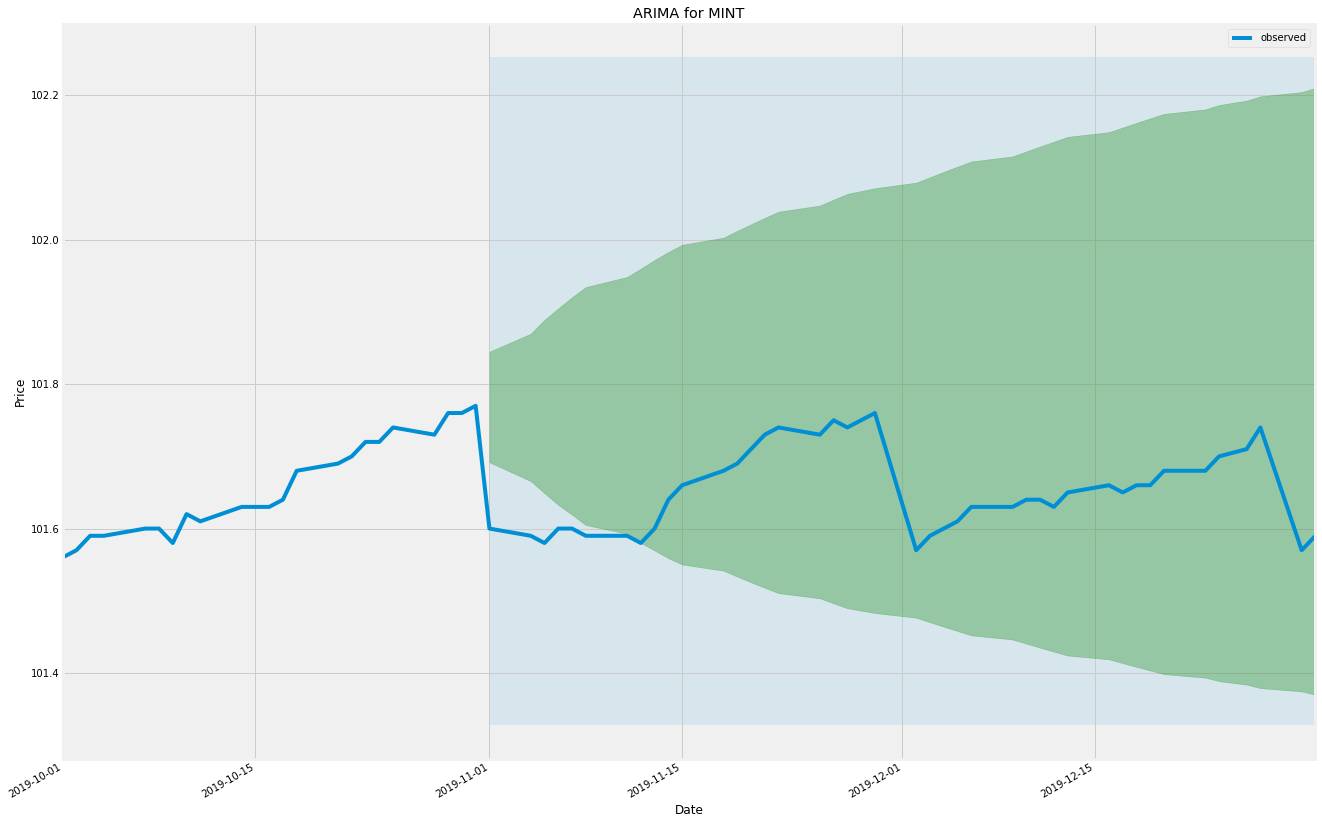

In [18]:
ax = ts['2019-10':].plot(label='observed', figsize=(20, 15))
# datum.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-11-01'), price_forecasted.index[-1], alpha=.1, zorder=-1)

plt.title('ARIMA for MINT')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.savefig('mint_arima2.png')
plt.show()

In [19]:
price_forecasted = pred_dynamic.predicted_mean
price_truth = ts['2019-11-01':]

# Compute the mean square error
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.02


In [20]:
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


## FBProphet for Future

In [21]:
from fbprophet import Prophet as proph
spy = pd.DataFrame(data[0]['close']).reset_index()
spy.columns = ['ds', 'y']

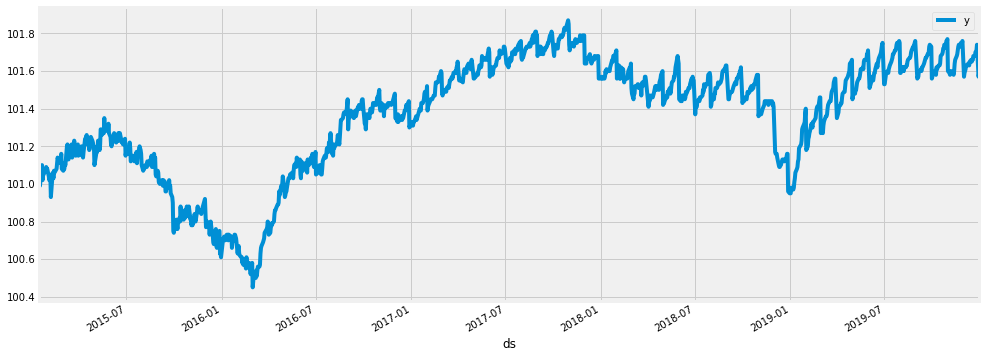

In [22]:
spy.set_index('ds').plot()

In [23]:
p = proph(interval_width=.95)
p.fit(spy)
inp = p.make_future_dataframe(periods=30, freq='D')
out = p.predict(inp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\jayar\anaconda\Anaconda3\envs\PandaSpace\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [24]:
df = out[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [25]:
mint_df_novjan = df.tail(71)
mint_df_novjan.dtypes

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
dtype: object

In [26]:
# def get_iex_data(stock_list, start=datetime(2019,11,1), end=datetime(2020,1,10)):
#     return_list = []
#     for i in stock_list:
#         df = pd.DataFrame(get_historical_data(i, start, end, output_format='pandas', token='pk_d28c0190de7a4d6da30b3bd2b08487c8'))
#         df['ticker'] = i
#         return_list.append(df)
#     return return_list
# etf = ['VV']
# data = get_iex_data(etf)
# pull = data[0]['close']
# pull_df = pd.DataFrame(pull)

In [27]:
# pull_df

In [28]:
mint_yf = pd.read_csv('MINT_yf.csv')
mint_yf = mint_yf.rename(columns={"Date": "ds"})
mint_yf['ds'] = pd.to_datetime(mint_yf['ds'])

mint_yf.dtypes

ds           datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [29]:
mint_yf1 = mint_yf[['ds','Adj Close']]
mint_yf1

,ds,Adj Close
0,2019-11-01,101.210945
1,2019-11-04,101.200981
2,2019-11-05,101.191025
3,2019-11-06,101.210945
4,2019-11-07,101.210945
5,2019-11-08,101.200981
6,2019-11-11,101.200981
7,2019-11-12,101.191025
8,2019-11-13,101.210945
9,2019-11-14,101.250786


In [30]:
comb = mint_df_novjan.join(mint_yf1.set_index('ds'), on='ds')
# comb = comb.set_index('ds')
comb['difference'] = comb['Adj Close'] - comb['yhat']
comb['difference_pct'] = comb['difference']/comb['Adj Close']
comb['difference_pct'] = comb['difference_pct'].map("{:.2%}".format)
comb.to_csv('mint_predict_fbprophet.csv', encoding='utf-8')
comb = comb.drop([1249])
comb = comb.drop([1252])
comb = comb.drop([1253])
comb = comb.drop([1259])
comb = comb.drop([1260])
comb = comb.drop([1266])
comb = comb.drop([1267])
comb = comb.drop([1268])
comb = comb.drop([1273])
comb = comb.drop([1274])
comb.tail(50)

,ds,yhat,yhat_lower,yhat_upper,Adj Close,difference,difference_pct
1219,2019-11-18,101.677704,101.572301,101.772788,101.290642,-0.387062,-0.38%
1220,2019-11-19,101.678846,101.580289,101.774284,101.300606,-0.378240,-0.37%
1221,2019-11-20,101.680979,101.579375,101.775493,101.320518,-0.360461,-0.36%
1222,2019-11-21,101.684683,101.586486,101.780454,101.340446,-0.344237,-0.34%
1223,2019-11-22,101.685220,101.586465,101.783158,101.350410,-0.334810,-0.33%
1224,2019-11-25,101.684263,101.582757,101.785667,101.340446,-0.343817,-0.34%
1225,2019-11-26,101.684306,101.589465,101.790459,101.360374,-0.323932,-0.32%
1226,2019-11-27,101.685153,101.583847,101.784235,101.350410,-0.334743,-0.33%
1227,2019-11-29,101.686322,101.584520,101.786194,101.370338,-0.315984,-0.31%
1228,2019-12-02,101.679848,101.571838,101.768353,101.380318,-0.299530,-0.30%


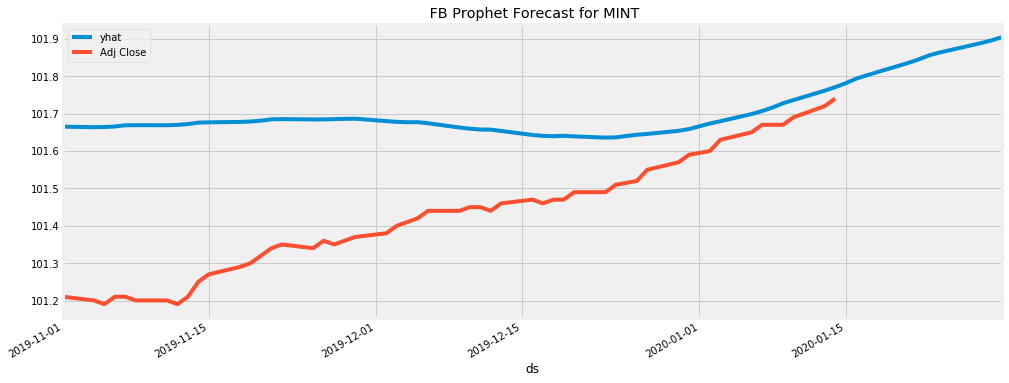

In [31]:
comb.plot(x="ds", y=["yhat", "Adj Close"], kind="line")
plt.title(' FB Prophet Forecast for MINT')
plt.savefig('mint_fbproph_forecast.png')

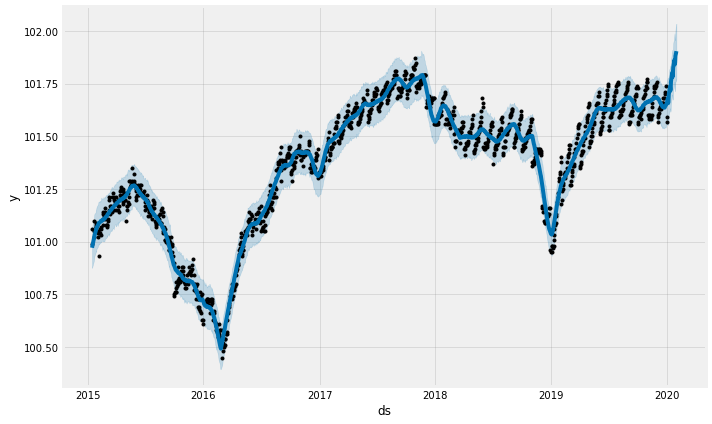

In [32]:
p.plot(df)
plt.savefig('mint_fbp2.png')

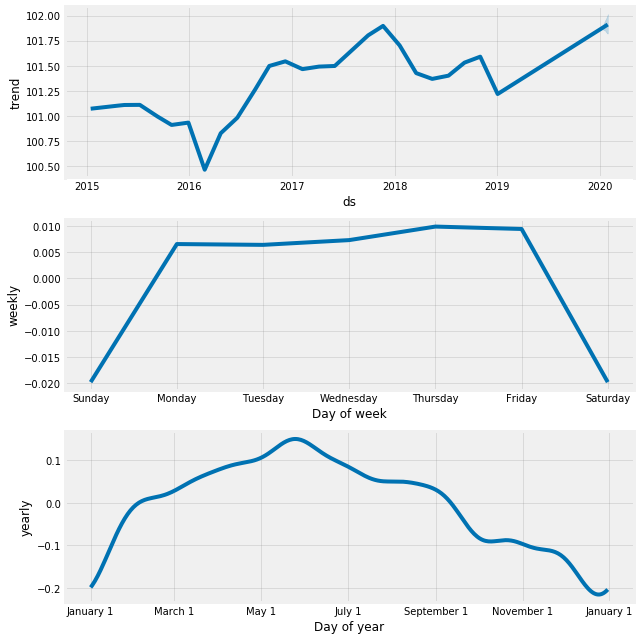

In [33]:
p.plot_components(out)
# plt.title('DIA Seasonality Trends')
plt.savefig('mint_seasonality.png')

In [34]:
split = pd.to_datetime('2019-12-01')
true = spy.set_index('ds')[split:]
past = spy.set_index('ds')[:split].reset_index()

In [35]:
pro = proph(interval_width=.95)
pro.fit(past)
inp = pro.make_future_dataframe(periods=20, freq='D').set_index('ds')[split:].reset_index()
out = pro.predict(inp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
pred = out[['ds', 'yhat']].set_index('ds')
pred

,yhat
ds,
2019-12-01,101.609188
2019-12-02,101.663991
2019-12-03,101.659327
2019-12-04,101.654392
2019-12-05,101.651014
2019-12-06,101.643741
2019-12-07,101.576134
2019-12-08,101.569054
2019-12-09,101.620674
